## 2-я часть. Выбор и построение модели для предсказания целевого действия

### Структура файла

---
#### Блок моделирования:

* Загрузка данных и создание основного датасета.
* Создание Pipeline для предобработки данных.
* Разделение данных на обучающую и тестовую выборки с применением undersampling для балансировки классов.
* Обучение и сравнение моделей (`LogisticRegression`, `RandomForest`, `MLPClassifier`, `XGBoost`, `LightGBM`, `CatBoost`).
* Подбор гиперпараметров для лучшей модели.
* Подготовка финальной модели, обучение на всем датасете.
* Сохранение и загрузка финальной модели.
* Проверка загруженной модели, тестирование на выборке из основного датасета.

#### Результаты:
* Таблицы с метриками моделей (ROC-AUC, precision, recall, F1, accuracy).
* Визуализация важности признаков и ROC-кривых.

### Общие выводы по проекту

___
#### Сравнение моделей:

Лучшие результаты по ROC-AUC на тестовой выборке показали бустинговые модели
   * `XGBoost` (**0.7057**)
   * `LightGBM` (**0.7051**)
   * `CatBoost` (**0.7047**).
   * `RandomForest` также показал хорошие результаты (ROC-AUC: **0.7024**), но уступил бустинговым методам.
   * `LogisticRegression` и `MLPClassifier` оказались менее эффективными (ROC-AUC: **0.6710** и **0.6676** соответственно).
___
#### Время обучения:

* `XGBoost` и `LightGBM` оказались самыми быстрыми (0.8 и 2.3 секунды соответственно).
* `CatBoost` потребовал больше времени (24.85 секунд), что связано с его особенностями реализации.
* `MLPClassifier` показал наибольшее время обучения (41.34 секунды), что делает его менее предпочтительным для больших данных.
___
#### Важность признаков:

#### Группы признаков распределились по суммарной важности в % следующим образом:
- `utm` **39.33%**
- `visit` **28.4%**
- `device` **19.33%**
- `geo` **12.93%**

#### Самые значимые признаки (более 4.0%) по группам:

- **utm**
   - `utm_campaign`	 **10,43%**
   - `utm_source`	 **9,60%**
   - `utm_adcontent` **8,60%**
   - `utm_keyword`   **6,40%**

- **visit**
   - `visit_day_of_month` **6,77%**
   - `visit_number`	      **6,67%**
   - `visit_hour`	      **5,30%**

- **device**
   - device_screen_height	 **4,57%**
   - device_browser_freq	 **4,43%**

- **geo**
   - `geo_longitude` **4,87%**
   - `geo_latitude` **4,50%**

___
#### Выводы и решения:

* Для дальнейшего использования рекомендуется модели `XGBoost` и `LightGBM`, как наиболее сбалансированные по показателям ROC-AUC и скорости работы.
* Для улучшения метрик можно провести более глубокой подбор гиперпараметров или экспериментировать с другими методами балансировки классов.
* В данном случае я принял решение в качестве лучшей модели использовать модель `LightGBM`.
___
#### Итоги:

* Проект успешно решает задачу предсказания целевого события с использованием современных методов машинного обучения.
* Лучшая модель (`LightGBM`) демонстрирует стабильные результаты и может быть развернута в production.
___

## Импорт библиотек

In [306]:
import pandas as pd
import numpy as np
import time
import dill
from datetime import datetime

# --------------------------------------
import matplotlib_inline
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------
from sklearnex import patch_sklearn        # патч - ускорение библиотеки scikit-learn
patch_sklearn()

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import TargetEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, mean_absolute_error, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.utils.class_weight import compute_class_weight

from geopy.distance import geodesic

from itertools import cycle
import chime                               # звуки
import pyttsx3                             # преобразование текста в речь

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## Техническая часть (переменные, функции)

In [307]:
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
pd.set_option('display.max_colwidth', 100)

RANDOM_STATE = 42
TEST_SIZE = 0.2
MODEL_TUNING_TIME_LIMIT = 1800  # 30 минут в секундах
# IS_DEBUG = False
# -----------------------------------------------------------------------------------------------------------------
# Глобальные параметры (переменные)
# Названия файлов с данными
filename_sessions   = 'data/ga_sessions.pkl'
filename_hits       = 'data/ga_hits.pkl'

s_bold = '\033[1m'

In [308]:
dt_start = datetime.now()
print(dt_start.strftime("%Y-%m-%d %H:%M:%S"))

2025-07-22 09:16:17


#### Функция: Вывод продолжительности выполнения кода

In [309]:
# Вывод продолжительности выполнения кода
def get_duration_time(dt_start): 
    dt_finish = datetime.now()
    dt_duration = dt_finish - dt_start
    print(f'Начало = {dt_start.strftime("%Y-%m-%d (%H:%M:%S)")};  Окончание = {dt_finish.strftime("%Y-%m-%d (%H:%M:%S)")};  Продолжительность = ({str(dt_duration).split('.')[0]})')

#### Функция преобразования текста в речь

In [310]:
# Преобразования текста в речь
def text_to_speech(text):
    chime.info()
    time.sleep(2)

    engine = pyttsx3.init()  # Инициализация движка
    engine.say(text)         # текст для озвучки

    try:
        engine.runAndWait()
    except RuntimeError:     # Если движок уже запущен, останавливать и запускать снова
        engine.endLoop()    
        engine.runAndWait()
    finally:
        del engine           # Удаление объект движка

In [311]:
# вывод информации о % заполнения датасета
def print_useful_rows_info(df):
    print(f'Количество полностью заполненных объектов из всей выборки: {len(df.dropna())}')
    print(f'Процент полностью заполненных объектов из всей выборки:    {round(len(df.dropna()) / len(df) * 100, 2)}')

In [312]:
# Вывод списка незаполненных значений столбцов и % заполнения
def print_list_missing_values(df):
    missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending = False)

    print('\nПроцент пропущенных значений:')
    # missing_values
    print(missing_values[missing_values != 0].index.to_list())
    print()
    print(missing_values[missing_values != 0])

#---------------------------------------------------------------------------------
# Вывод списка незаполненных столбцов и % пропусков в данных
# Заполнение датасета
# print_useful_rows_info(x_train_processed)

# список незаполненных столбцов и % заполнения 
# print_list_missing_values(x_train_processed)

In [313]:
# Вывод списка незаполненных столбцов и % пропусков в данных
# Заполнение датасета ДО обработки
print_useful_rows_info(x_train_processed)

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(x_train_processed)

Количество полностью заполненных объектов из всей выборки: 120753
Процент полностью заполненных объектов из всей выборки:    100.0

Процент пропущенных значений:
[]

Series([], dtype: float64)


In [314]:
# Функция форматирования времени
def format_time(seconds):
    return f'{int(seconds // 3600):02d}:\
            {int((seconds % 3600) // 60):02d}:\
            {int(seconds % 60):02d}.{int(seconds % 1 * 1000):03d}'

In [315]:
# Получение датафрейма с важностью признаков 
def get_features_importance_df(model, x_train):
    if not hasattr(model, 'feature_importances_'):
        raise ValueError("Модель не имеет атрибута feature_importances_")
    
    feature_names = x_train.columns
    importances = model.feature_importances_
    importances_percent = (importances / importances.sum()) * 100
    
    # Создаю DataFrame
    df_importance = pd.DataFrame({
                                    'Признак':    feature_names,
                                    'Важность':   importances,
                                    'Важность_%': importances_percent
                                })
    
    # Сортировка по важности (по убыванию)
    df_importance = df_importance.sort_values('Важность', ascending=False)
    
    return df_importance.reset_index(drop=True)

In [316]:
# Визуализация важности признаков в процентах
def plot_features_importance(model, x_train, top_n=20, figsize=(8, 5), font_scale=0.8, bar_width=0.7):
    """
    --------------------------------------------------------------------------------
    Визуализация важности признаков в процентах
    --------------------------------------------------------------------------------
    Параметры:
    --------------------------------------------------------------------------------
    model 		: object 		- Обученная модель
    x_train 	: pd.DataFrame 	- Обучающие данные
    top_n 		: int 			- Количество топовых признаков (по умолчанию 20)
    figsize 	: tuple 		- Размер графика (по умолчанию (8, 5))
    font_scale 	: float 		- Масштаб шрифта (по умолчанию 0.8)
    bar_width 	: float 		- Ширина столбцов (по умолчанию 0.7)
    --------------------------------------------------------------------------------
    """
    if not hasattr(model, 'feature_importances_'):
        raise ValueError("Модель не имеет атрибута feature_importances_")
    
    # Стиль
    sns.set_style("whitegrid")
    sns.set(font_scale=font_scale)
    
    # Сами данные
    df_importance = get_features_importance_df(model, x_train).head(top_n)
    
    # График
    plt.figure(figsize=figsize)
    ax = sns.barplot(
                        data=df_importance,
                        x='Важность_%',
                        y='Признак',
                        hue='Признак',
                        palette='viridis',
                        legend=False,
                        dodge=False,
                        width=bar_width
                    )
    
    # Настройка подписей
    ax.set_title('Важность признаков (%)', fontsize=14, weight='bold', pad=10)
    ax.set_xlabel('Важность (%)', fontsize=10)
    ax.set_ylabel('')
    
    # Уменьшаю отступы
    plt.tight_layout(pad=1)
    
    # Метки занченй для столбцов столбцы (только если достаточно места)
    if top_n <= 50:
        for p in ax.patches:
            width = p.get_width()
            if width >= 0:  # Подписываю только значимые значения
                ax.text(
                            width + 0.2,
                            p.get_y() + p.get_height()/2.,
                            f'{width:.1f}%',
                            ha='left',
                            va='center',
                            fontsize=9,  # 7
                            # color = '#FF6B6B' if width > 1  else 'black'
                            color = 'blue' if width > 1  else 'black'
                    
                        )
    
    # Убираю лишние линии
    sns.despine(left=True, bottom=True)
    plt.show()

In [317]:
# Визуализация кривых ROC_AUC для нескольких моделей
def plot_roc_curves(x_test, y_test, models_results, pipe_final=None):

    sns.reset_orig()  # Возвращаю стиль matplotlib к дефолтному (убирает seaborn-стили)
    plt.rcdefaults()  # Сбрасываю все кастомные настройки matplotlib
    
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    sns.set(style="whitegrid")
    
    # 1. --- Кривые для всех моделей из сравнения
    for idx, model_info in enumerate(models_results):
        
        model_name = model_info['model_name']
        model      = model_info['pipeline']

        # Получение вероятности для положительного класса
        y_proba = model.predict_proba(x_test)[:, 1]
        
        # Рассчитываю ROC-кривую
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc     = auc(fpr, tpr)
        
        # График кривой
        plt.plot(fpr, tpr, color=next(colors), lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

    # 2. --- Кривая для финальной модели
    if pipe_final is not None:
        
        y_proba_final           = pipe_final.predict_proba(x_test)[:, 1]
        fpr_final, tpr_final, _ = roc_curve(y_test, y_proba_final)
        roc_auc_final           = auc(fpr_final, tpr_final)
        
        plt.plot(fpr_final, tpr_final, color='black', linestyle='--', lw=4, label=f'Final Model (AUC = {roc_auc_final:.4f})')
    
    # Оформление графика
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    
    plt.grid(True)
    plt.show();
    # plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')

## Функции (этапы моделирования)

In [318]:
# -----------------------------------------------------------------------------------------------------------------
# Загрузка исходных данных из файла; получение основного датасета для работы
def read_source_data(is_debug=False):

    if is_debug:
        text = sys._getframe().f_code.co_name        # text = 'read_source_data'
        print(f'{'-' * 100}\nВыполняется функция: {text} ...')

    # -----------------------------------------------------------------------------------------------------------------
    # 1. df_sessions
    print('-' * 100)
    print(f'Чтение файла {filename_sessions}')
    df_sessions = pd.read_pickle(filename_sessions)
    get_duration_time(dt_start)
    print('-' * 100)
    print(f'Чтение файла {filename_hits}')
    df_hits     = pd.read_pickle(filename_hits)
    get_duration_time(dt_start)

    # размеры датасетов и списки столбцов
    print('-' * 100)
    print(f'df_sessions; {df_sessions.shape}\n')
    print(df_sessions.columns)
    print()
    print(f'df_hits; {df_hits.shape}\n')
    print(df_hits.columns)

    # -----------------------------------------------------------------------------------------------------------------
    # 2. df_hits
    # Удаляю лишние столбцы, которые по условию задачи будут не нужны. Оставляю только 'session_id' и 'event_action'.
    columns_to_drop = [col for col in df_hits.columns if col not in ['session_id', 'event_action']]
    df_hits.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Созадаю новый столбец is_target_action - числовая целевая переменная (значения 1 и 0)
    # Удаляю столбец event_action, оставляю только session_id и target_event_action
    list_target_event_actions = ['sub_car_claim_click',
                                'sub_car_claim_submit_click',
                                'sub_open_dialog_click',
                                'sub_custom_question_submit_click',
                                'sub_call_number_click',
                                'sub_callback_submit_click',
                                'sub_submit_success',
                                'sub_car_request_submit_click']

    df_hits['target_event_action'] = df_hits['event_action'].isin(list_target_event_actions).astype(int)
    df_hits.drop(columns=['event_action'], inplace=True, errors='ignore')

    # Группирую данные в df_hits по session_id + функция агрегирования MAX(target_event_action)
    df_hits_grouped = df_hits.groupby('session_id')['target_event_action'].max().reset_index()

    # -----------------------------------------------------------------------------------------------------------------
    # 4. Соединяю два датасета df_sessions и df_hits_grouped в один основной
    df_sessions = df_sessions.merge(
                                        df_hits_grouped,
                                        on='session_id',
                                        how='left',
                                        indicator=False
                                    )
    df_sessions['target_event_action'] = df_sessions['target_event_action'].fillna(0).astype(int)

    # -----------------------------------------------------------------------------------------------------------------
    x = df_sessions.drop('target_event_action', axis=1)
    y = df_sessions['target_event_action']

    print(f'\n{'-' * 100}')
    print(f'Итоговый датасет df_sessions; {df_sessions.shape}\n')
    get_duration_time(dt_start)

    return df_sessions
    # return x, y

In [367]:
# Подготовка и разделение данных
def prepare_and_split_data(a_df, coef_classes=2):
    
    # ---------------------------------------------------------------------------------------------------
    # Разделение датасета на train и test
    if coef_classes == 0:    # начальный вариант - используется весь датасет

        x = a_df.drop(['target_event_action'], axis=1)
        y = a_df['target_event_action']
    else:                    # уменьшение размера класса 0 (undersampling)
        
        df_class_0 = a_df[ a_df['target_event_action'] == 0]
        df_class_1 = a_df[ a_df['target_event_action'] == 1]
    
        # Undersampling: оставляю запсией в {coef_size_class} раз больше, чем класс 1; соотношение (1 : coef_size_class)
        n_class_1          = len(df_class_1)
        coef_size_class    = coef_classes
        df_class_0_sampled = df_class_0.sample(n = coef_size_class * n_class_1, random_state = 42)
    
        # Собираю сбалансированный датасет
        df_balanced = pd.concat([df_class_0_sampled, df_class_1])
        print()
        print('Размерности классов ДО    уменьшения класса 0:\t df_class_0  =', df_class_0.shape,         '\tdf_class_1 =', df_class_1.shape)
        print('Размерности классов ПОСЛЕ уменьшения класса 0:\t df_class_0  =', df_class_0_sampled.shape, '\tdf_class_1 =', df_class_1.shape)
        print('Размерности сбалансированного датасета:\t\t df_balanced =', df_balanced.shape)
        
        x = df_balanced.drop('target_event_action', axis=1)
        y = df_balanced['target_event_action']

    # ---------------------------------------------------------------------------------------------------
    # train_test_split - Разделение датасета на train и test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    print('Размеры датасетов:')
    print(  f'\t x       = {x.shape};      \t   y       = {x.shape}' + 
          f'\n\t x_train = {x_train.shape};\t   y_train = {y_train.shape}' +
          f'\n\t x_test  = {x_test.shape}; \t   y_test  = {y_test.shape}')
    
    return x, y, x_train, x_test, y_train, y_test

#### Функции и классы для Pipeline (FunctionTransformer and ColumnTransformer)

In [320]:
# -----------------------------------------------------------------------------------------------------------------
# Удаление выбранных столбцов из датасета (в начале обработки)
def drop_columns_first(a_df, is_debug=False):
    import sys

    text = sys._getframe().f_code.co_name        # text = 'prepare_data_set_types'
    if is_debug:
        print(f'{'-' * 100}\nВыполняется функция: {text} ...')
    else:
        print(f'{'-' * 100}\nВыполняется функция: {text} ...')

    # Вывод информации о незаполненных столбцах и % пропусков в данных
    # print_info_about_missing(a_df)

    columns_to_drop = ['device_model']
    return a_df.drop(columns_to_drop, axis=1, errors='ignore')

# -----------------------------------------------------------------------------------------------------------------
# Преобразования типов данных
def prepare_data_set_types(a_df, is_debug=False):
    import pandas as pd
    import sys
    
    text = sys._getframe().f_code.co_name        # text = 'prepare_data_set_types'
    if is_debug:
        print(f'{'-' * 100}\nВыполняется функция: {text} ...')
    else:
        print(f'{'-' * 100}\nВыполняется функция: {text} ...')
        

    # дата и время - тип даtetime
    a_df['visit_date'] = pd.to_datetime( a_df['visit_date'], errors='coerce')
    a_df['visit_time'] = pd.to_datetime( a_df['visit_time'], format='%H:%M:%S', errors='coerce')

    return a_df

# -----------------------------------------------------------------------------------------------------------------
# Заполнение "проблемных" значений признаков
class ValueReplacer(BaseEstimator, TransformerMixin):

    def __init__(self, is_debug=False):
        self.brand_mode_ = None
        self.browser_mode_ = None
        self.brand_replace_values_ = ['', '(not set)', 0]
        self.columns_ = None  # Будет установлено в fit
        self.is_debug = is_debug
        self._sklearn_output_config = {"transform": "default"}

    def set_debug(self, is_debug):
        self.is_debug = is_debug
        return self
        
    def set_output(self, *, transform=None):
        self._sklearn_output_config = {"transform": transform}
        return self

    def fit(self, X, y=None):
        # Сохраняем имена столбцов, если X - DataFrame

        X_df = X.copy()

        self.brand_mode_    = X_df['device_brand'].mode()[0]
        self.browser_mode_  = X_df['device_browser'].mode()[0]

        X['device_brand']   = X['device_os'].fillna(self.brand_mode_)
        X['device_browser'] = X['device_browser'].fillna(self.brand_mode_)

        return self

    def transform(self, X):
        if self.is_debug:
            print('-' * 100 + '\nВыполняется ValueReplacer ...')
            print(f"На входе = {X.shape}; cтолбцы:\n", X.columns.tolist())
        else:
            print('-' * 100 + '\nВыполняется ValueReplacer ...')

        X = X.copy()

        X['device_brand']   = X['device_os'].fillna(self.brand_mode_)
        X['device_browser'] = X['device_browser'].fillna(self.brand_mode_)
        
        # 1. Замена проблемных значений в device_brand
        if 'device_brand' in X.columns:
            X.loc[X['device_brand'].isin(self.brand_replace_values_), 'device_brand'] = 'other'

        # 2. Замена (not set) в device_browser
        if 'device_browser' in X.columns:
            X.loc[X['device_browser'] == '(not set)', 'device_browser'] = self.browser_mode_

        # 3. Замена utm_medium
        if 'utm_medium' in X.columns:
            X.loc[(X['utm_medium'] == '(none)') | (X['utm_medium'] == '(not set)'), 'utm_medium'] = 'other'

        if self.is_debug:
            print(f"На выходе = {X.shape}; cтолбцы:\n", X.columns.tolist())
            
        return X


# -----------------------------------------------------------------------------------------------------------------
# Заполнение "проблемных" значений для device_os
class DeviceOSImputer(BaseEstimator, TransformerMixin):

    def __init__(self, is_debug=False):
        self.brand_os_map_ = {}  # Будет хранить топ-1 OS для каждого бренда
        self.global_mode_ = None  # Глобальная мода для резервной замены
        self.is_debug = is_debug
        self._sklearn_output_config = {"transform": "default"}

    def set_debug(self, is_debug):
        self.is_debug = is_debug
        return self
        
    def set_output(self, *, transform=None):
        self._sklearn_output_config = {"transform": transform}
        return self

    def fit(self, X, y=None):

        X = X.copy()

        # Заменяем пропуски на маркер
        X['device_os'] = X['device_os'].fillna('(not set)')

        # Создаем таблицу бренд -> топ-1 OS (исключая маркер '(not set)')
        valid_os = X[X['device_os'] != '(not set)']

        # Группируем и находим топ-1 OS для каждого бренда
        self.brand_os_map_ = (
                                valid_os.groupby('device_brand')['device_os']
                                .apply(lambda x: x.value_counts().index[0])
                                .to_dict()
                            )

        # Запоминаем глобальную моду
        self.global_mode_ = valid_os['device_os'].mode()[0] if not valid_os['device_os'].empty else 'other'

        return self

    def transform(self, X):
        
        if self.is_debug:
            print('-' * 100 + '\nВыполняется DeviceOSImputer ...')
            print(f"На входе = {X.shape}; cтолбцы:\n", X.columns.tolist())
        else:
            print('-' * 100 + '\nВыполняется DeviceOSImputer ...')

        X = X.copy()

        # 1. Первичная замена пропусков на маркер
        X['device_os'] = X['device_os'].fillna('(not set)')

        # 2. Замена маркера на топ-1 OS для бренда
        mask = X['device_os'] == '(not set)'
        X.loc[mask, 'device_os'] = X.loc[mask, 'device_brand'].map(self.brand_os_map_)

        # 3. Замена оставшихся пропусков на глобальную моду
        X['device_os'] = X['device_os'].fillna(self.global_mode_)

        # 4. Замена 0 и прочих невалидных значений
        X.loc[X['device_os'].isin([0, '', '(not set)']), 'device_os'] = self.global_mode_

        if self.is_debug:
            print(f"На выходе = {X.shape}; cтолбцы:\n", X.columns.tolist())
        return X


# -----------------------------------------------------------------------------------------------------------------
# Заполнение "проблемных" значений для гео данных
class GeoDataImputer(BaseEstimator, TransformerMixin):

    def __init__(self, is_debug=False):
        self.top_country_ = None
        self.country_city_map_ = {}
        self.city_mode_ = None
        self.is_debug = is_debug
        self._sklearn_output_config = {"transform": "default"}

    def set_debug(self, is_debug):
        self.is_debug = is_debug
        return self

    def set_output(self, *, transform=None):
        self._sklearn_output_config = {"transform": transform}
        return self

    def fit(self, X, y=None):
        X = X.copy()

        # 1. Определяем топ-1 страну
        country_counts = X.groupby('geo_country')['session_id'].count()
        self.top_country_ = country_counts.idxmax()

        # 2. Создаем маппинг страна -> топ-1 город
        valid_cities = X[X['geo_city'] != '(not set)']
        self.country_city_map_ = (
            valid_cities.groupby('geo_country')['geo_city']
            .apply(lambda x: x.value_counts().index[0])
            .to_dict()
        )

        # 3. Запоминаем глобальную моду для городов
        self.city_mode_ = valid_cities['geo_city'].mode()[0] if not valid_cities['geo_city'].empty else 'other'

        return self

    def transform(self, X):
        if (self.is_debug):
            print('-' * 100 + '\nВыполняется GeoDataImputer ...')
            print(f"На входе = {X.shape}; cтолбцы:\n", X.columns.tolist())
        else:
            print('-' * 100 + '\nВыполняется GeoDataImputer ...')

        X = X.copy()

        # 1. Обработка geo_country
        X.loc[X['geo_country'] == '(not set)', 'geo_country'] = (self.top_country_ if self.top_country_ != '(not set)' else 'other')

        # 2. Создаем временный ключ для merge
        X['key_country_city'] = X['geo_country'] + '_(not set)'

        # 3. Замена geo_city
        # Сначала заменяем '(not set)' на топ-1 город для страны
        mask = X['geo_city'] == '(not set)'
        X.loc[mask, 'geo_city'] = X.loc[mask, 'geo_country'].map(self.country_city_map_)

        # Затем заполняем оставшиеся пропуски
        X['geo_city'] = X['geo_city'].fillna(self.city_mode_)

        # 4. Удаляем вспомогательные колонки
        X.drop(columns=['key_country_city'], inplace=True, errors='ignore')

        # 5. Обновляем ключ (если нужно сохранить)
        X['key_country_city'] = X['geo_country'] + '_' + X['geo_city']

        if self.is_debug:
            print(f"На выходе = {X.shape}; cтолбцы:\n", X.columns.tolist())

        # X = X.reset_index(drop=True)
        return X


# -----------------------------------------------------------------------------------------------------------------
# Создание новых признаков
class FeatureGenerator(BaseEstimator, TransformerMixin):

    def __init__(self, is_debug=False):
        self.is_debug = is_debug
        self.screen_res_mode_ = None
        self.aspect_ratio_mode_ = None
        self.client_first_visit_ = None
        self._sklearn_output_config = {"transform": "default"}

    def set_debug(self, is_debug):
        self.is_debug = is_debug
        return self

    def set_output(self, *, transform=None):
        self._sklearn_output_config = {"transform": transform}
        return self

    def fit(self, X, y=None):
        # Запоминаем значения для transform
        self.screen_res_mode_ = X['device_screen_resolution'].mode()[0]
        self.aspect_ratio_mode_ = X['device_screen_aspect_ratio'].mode()[0] if 'device_screen_aspect_ratio' in X.columns else 1.0
        self.client_first_visit_ = X.groupby('client_id')['visit_date'].min()
        return self

    def transform(self, X):
        import pandas as pd

        if self.is_debug:
            print('-' * 100 + '\nВыполняется FeatureGenerator ...')
            print(f"На входе = {X.shape}; cтолбцы:\n", X.columns.tolist())
        else:
            print('-' * 100 + '\nВыполняется FeatureGenerator ...')

        X = X.copy()        #.reset_index(drop=True)
        
        if self.is_debug:
            print(f"\nИндексы на входе: {X.index[:5]}")

        # 1. Временные признаки
        X['visit_day_of_month'] = X['visit_date'].dt.day
        X['visit_day_of_week'] = X['visit_date'].dt.dayofweek + 1
        X['visit_hour'] = X['visit_time'].dt.hour

        # 2. Время суток
        time_bins = [0, 5, 9, 12, 16, 20, 24]
        time_labels = ['late_night', 'early_morning', 'morning', 'afternoon', 'evening', 'night']
        X['visit_time_of_day'] = pd.cut(X['visit_hour'], bins=time_bins, labels=time_labels, right=False)

        # 3. Пиковые часы (оптимизированная версия)
        peak_hours = {11, 12, 13, 14, 15, 16}
        X['visit_is_peak_hour'] = X['visit_hour'].apply(lambda x: 1 if x in peak_hours else 0)

        # 4. Обработка разрешения экрана
        X['device_screen_resolution'] = X['device_screen_resolution'].replace('(not set)', self.screen_res_mode_)

        # 5. Размеры экрана (векторизированная версия)
        screen_size = X['device_screen_resolution'].str.extract(r'(\d+)x(\d+)').astype(float)
        X[['device_screen_width', 'device_screen_height']] = (screen_size / 100).round() * 100

        # 6. Соотношение сторон (с обработкой крайних значений)
        X['device_screen_aspect_ratio'] = (X['device_screen_width'] / X['device_screen_height']).clip(0.5, 3)
        X['device_screen_aspect_ratio'] = X['device_screen_aspect_ratio'].fillna(self.aspect_ratio_mode_)

        # 7. Дни с первого визита (оптимизированная версия)
        original_index = X.index  # Сохраняем исходные индексы

        X = X.merge(
                    self.client_first_visit_.rename('visit_date_min').reset_index(),
                    on='client_id',
                    how='left'
                )

        X.index = original_index    # Восстанавливаем исходные индексы

        X['visit_days_since_first_visit'] = (X['visit_date'] - X['visit_date_min']).dt.days
        X['visit_days_since_first_visit'] = X['visit_days_since_first_visit'].fillna(0)

        X.drop(columns=['visit_date_min'], inplace=True)

        # 8. Признаки трафика
        organic_sources = {'(none)', 'organic', 'referral'}
        social_sources = {
                            'QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs',
                            'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm'
                        }

        X['utm_is_organic_traffic'] = X['utm_medium'].isin(organic_sources).astype(int)
        X['utm_is_advertising_in_social_networks'] = X['utm_source'].isin(social_sources).astype(int)

        if self.is_debug:
            print(f"На выходе = {X.shape}; cтолбцы:\n", X.columns.tolist())
            print(f"\nИндексы на выходе: {X.index[:5]}")
            
        # X = X.reset_index(drop=True)  # Сброс индексов
        return X


# -----------------------------------------------------------------------------------------------------------------
# Создание новых признаков
# Новые признаки - Географические координаты места - geo_latitude (Широта) и geo_longitude (Долгота)
    # определяются по стране и городу
    # координаты были получены с помощьюю библиотеки geopy
    # полученные координаты были сохранены в готовом виде в csv-файле locations.csv
    # здесь по умолчанию задан режим source_location = 'csv_file', т.е. координаты брать из файла (для экономии времени)
class GeoFeaturesGenerator(BaseEstimator, TransformerMixin):
    import pandas as pd

    def __init__(self, locations_file='models/locations.csv', target_city_coords=(55.7558, 37.6176), is_debug=False):
        self.locations_file = locations_file
        self.target_city_coords = target_city_coords
        self.is_debug = is_debug
        self.geo_data_ = None
        self.median_cache_ = {}
        self._sklearn_output_config = {"transform": "default"}

        # Проверка доступности geopy при инициализации
        try:
            from geopy.distance import geodesic
            self._geodesic = geodesic
        except ImportError:
            raise ImportError("Для работы GeoFeaturesGenerator требуется установить geopy: pip install geopy")
            
    def set_debug(self, is_debug):
        self.is_debug = is_debug
        return self
        
    def set_output(self, *, transform=None):
        self._sklearn_output_config = {"transform": transform}
        return self

    def _load_geo_data(self):
        import pandas as pd

        """Загрузка геоданных из CSV"""
        geo_data = pd.read_csv(self.locations_file)
        geo_data.rename(columns={
                                    'latitude': 'geo_latitude',
                                    'longitude': 'geo_longitude'
                                }, inplace=True)
        return geo_data

    def _calculate_distances(self, df):
        from geopy.distance import geodesic
        
        """Расчет расстояний до целевого города"""
        mask = df['geo_latitude'].notna()
        df.loc[mask, 'geo_distance_to_city_km'] = df[mask].apply(
                    # lambda row: self._geodesic((row['geo_latitude'], row['geo_longitude']), self.target_city_coords).km, axis=1)
                    lambda row: geodesic((row['geo_latitude'], row['geo_longitude']), self.target_city_coords).km, axis=1)
        return df

    def _fill_geo_missing(self, df):
        # Заполнение пропущенных геоданных
        geo_cols = ['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km']

        # Шаг 1: По странам и городам
        country_city_medians = df.groupby(['geo_country', 'geo_city'])[geo_cols].transform('median')
        df[geo_cols] = df[geo_cols].fillna(country_city_medians)

        # Шаг 2: По городам
        city_medians = df.groupby('geo_city')[geo_cols].transform('median')
        df[geo_cols] = df[geo_cols].fillna(city_medians)

        # Шаг 3: По странам
        country_medians = df.groupby('geo_country')[geo_cols].transform('median')
        df[geo_cols]    = df[geo_cols].fillna(country_medians)

        # Шаг 4: Глобальные медианы
        global_medians = df[geo_cols].median()
        df[geo_cols]   = df[geo_cols].fillna(global_medians)

        return df

    def fit(self, X, y=None):
        # Загружаем и подготавливаем справочник геоданных
        self.geo_data_ = self._load_geo_data()
        self.geo_data_ = self._calculate_distances(self.geo_data_)

        # Кэшируем медианы для быстрого заполнения
        numeric_cols = ['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km']
        self.median_cache_ = {
                                'country_city': self.geo_data_.groupby(['geo_country', 'geo_city'])[numeric_cols].median(),
                                'city':         self.geo_data_.groupby('geo_city')[numeric_cols].median(),
                                'country':      self.geo_data_.groupby('geo_country')[numeric_cols].median(),
                                'global':       self.geo_data_[numeric_cols].median()
                            }

        return self

    def transform(self, X):
        if self.is_debug:
            print('-' * 100 + '\nВыполняется GeoFeaturesGenerator ...')
            print(f"На входе = {X.shape}; cтолбцы:\n", X.columns.tolist())
        else:
            print('-' * 100 + '\nВыполняется GeoFeaturesGenerator ...')

        X = X.copy()    # .reset_index(drop=True)

        if self.is_debug:
            print(f"\nИндексы на входе: {X.index[:5]}")

        # Объединяем с геоданными
        original_index = X.index  # Сохраняем исходные индексы

        X = X.merge(
                        self.geo_data_[['geo_country', 'geo_city', 'geo_latitude', 'geo_longitude', 'geo_distance_to_city_km']],
                        on=['geo_country', 'geo_city'],
                        how='left'
                    )   #.reset_index(drop=True)

        X.index = original_index    # Восстанавливаем исходные индексы

        # Заполняем пропуски
        X = self._fill_geo_missing(X)

        if self.is_debug:
            print(f"На выходе = {X.shape}; cтолбцы:\n", X.columns.tolist())
            print(f"\nИндексы на выходе: {X.index[:5]}")

        # X = X.reset_index(drop=True)  # Сброс индексов
        return X


# -----------------------------------------------------------------------------------------------------------------
# Замена редких значений признаков
class ExactRareLabelEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, threshold_prc=1, rare_label='rare_value', is_debug=False):
        self.threshold_prc = threshold_prc  # процент для определения редких значений (1%)
        self.rare_label = rare_label
        self.rare_categories_ = {}          # будет хранить редкие категории для каждого столбца
        self.is_debug = is_debug
        self._sklearn_output_config = {"transform": "default"}

    def set_debug(self, is_debug):
        self.is_debug = is_debug
        return self

    def set_output(self, *, transform=None):
        self._sklearn_output_config = {"transform": transform}
        return self

    def fit(self, X, y):
        self.rare_categories_ = {}

        categorical_features = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword',
                                'device_category', 'device_os', 'device_brand', 'device_browser']

        # Работаем только с колонками, которые есть в данных
        cols_to_process = [col for col in categorical_features if col in X.columns]

        for col in cols_to_process:
            # Ваш оригинальный алгоритм:
            value_counts = X[col].value_counts()
            cnt_unique = X[col].nunique()
            threshold = max(1, int(cnt_unique * (self.threshold_prc / 100)))

            # Категории, где target_event_action всегда 0
            zero_target_mask = y.groupby(X[col]).sum() == 0

            # Редкие категории (по частоте И по target)
            rare_values = value_counts[ value_counts.index.isin(zero_target_mask[zero_target_mask].index) &
                                        (value_counts < threshold)
                                        ].index

            self.rare_categories_[col] = rare_values.tolist()

        return self

    def transform(self, X):
        if self.is_debug:
            print('-' * 100 + '\nВыполняется ExactRareLabelEncoder ...')
            print(f"На входе = {X.shape}; cтолбцы:\n", X.columns.tolist())
            print(f"\nИндексы на входе: {X.index[:5]}")
        else:
            print('-' * 100 + '\nВыполняется ExactRareLabelEncoder ...')

        X = X.copy()
        for col, rare_values in self.rare_categories_.items():
            if col in X.columns:
                X[col] = X[col].apply(lambda x: self.rare_label if x in rare_values else x)

        if self.is_debug:
            print(f"На выходе = {X.shape}; cтолбцы:\n", X.columns.tolist())
            print(f"\nИндексы на выходе: {X.index[:5]}")

        return X


# -----------------------------------------------------------------------------------------------------------------
# Категориальные признаки
    # Признаки со средней кардинальностью (10-100 уникальных значений)
    # метод Частотное ординальное кодирование (Frequency encoding)
        # Значение каждой категории заменяется на частоту встречаемости этой категории в наборе данных
class FrequencyEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, suffix='_encoded', is_debug=False):
        self.suffix = suffix
        self.is_debug = is_debug
        self.frequency_maps_ = {}
        self.feature_names_in_ = None
        self.feature_names_out_ = None
        self._sklearn_output_config = {"transform": "default"}

    def set_debug(self, is_debug):
        self.is_debug = is_debug
        return self

    def set_output(self, *, transform=None):
        self._sklearn_output_config = {"transform": transform}
        return self

    def fit(self, X, y=None):
        import pandas as pd

        # Преобразуем в DataFrame, если это numpy array
        if not hasattr(X, 'columns'):
            X = pd.DataFrame(X)

        # Сохраняем имена фичей для get_feature_names_out
        self.feature_names_in_ = X.columns.tolist()

        for col in X.columns:
            self.frequency_maps_[col] = X[col].value_counts(normalize=True).to_dict()

            # if self.is_debug:
            #     print(f"Frequencies for {col}:")
            #     print(self.frequency_maps_[col])

        # Генерируем имена выходных фичей
        self.feature_names_out_ = [f"{col}{self.suffix}" for col in X.columns]

        return self

    def transform(self, X):
        import pandas as pd

        if self.is_debug:
            print('-' * 100 + '\nВыполняется FrequencyEncoder ...')
            print(f"На входе = {X.shape}; cтолбцы:\n", X.columns.tolist())
        else:
            print('-' * 100 + '\nВыполняется FrequencyEncoder ...')

        # Преобразуем в DataFrame, если это numpy array
        if not hasattr(X, 'columns'):
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        X = X.copy()
        result = pd.DataFrame()

        for col in X.columns:
            new_col = f"{col}{self.suffix}"
            # result[new_col] = X[col].map(self.frequency_maps_[col])
            result[new_col] = X[col].map(self.frequency_maps_[col]).fillna(0)

        if self.is_debug:
            print(f"На выходе = {result.shape}; cтолбцы:\n", result.columns.tolist())
            
        return result

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_


# -----------------------------------------------------------------------------------------------------------------
# Удаление основных и вспомогательных столбцов после всех преобразований
def drop_unnecessary_columns(a_df, is_debug=False):
    # import pandas as pd
    from datetime import datetime
    import sys

    text = sys._getframe().f_code.co_name        # text = 'drop_unnecessary_columns'
    if is_debug:
        print(f'{'-' * 100}\nВыполняется функция: {text} ...')
        print('Кол-во столбцов =', len(a_df.columns), '\nСписок столбцов =', a_df.columns)
        print(f"На входе = {a_df.shape}; cтолбцы:\n", a_df.columns.tolist())
    else:
        print(f'{'-' * 100}\nВыполняется функция: {text} ...')

    # оригинальные и вспомогательные столбцы, ненужные после создания новых признаков
    list_columns_original = ['visit_date',
                             'visit_time',
                             'session_id',
                             'client_id',
                             'geo_country',
                             'geo_city',
                             'key_country_city',
                             'visit_date_min',
                             'device_model',
                             'device_screen_resolution']

    list_columns_medium_values = ['device_browser',
                                  'utm_medium']

    columns_to_drop = list_columns_original + list_columns_medium_values
    a_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Вывод информации о незаполненных столбцах и % пропусков в данных
    # print_info_about_missing(a_df)

    if is_debug:
        print(' ...Это была последняя функция в pipeline из списка FunctionTransformer')
        print(f"На выходе = {a_df.shape}; cтолбцы:\n", a_df.columns.tolist())

    return a_df

# -----------------------------------------------------------------------------------------------------------------
# Последний пустой трансформер
def last_step_transformer(a_df, is_debug=False):
    import sys

    text = sys._getframe().f_code.co_name        # text = 'last_transformer'
    if is_debug:
        print(f'{'-' * 100}\nВыполняется функция: {text} ...')
        print('Кол-во столбцов =', len(a_df.columns), '\nСписок столбцов =', a_df.columns)
        print(f"На входе = {a_df.shape}; cтолбцы:\n", a_df.columns.tolist())
    else:
        print(f'{'-' * 100}\nВыполняется функция: {text} ...')
        
    return a_df


In [321]:
# ------------------------------------------------------------------------------------------
# вкл / выкл отладочную информацию в pipeline
def set_pipeline_debug_mode(pipeline, is_debug):
    
    # Обновляем все кастомные трансформеры в пайплайне
    for step_name, step in pipeline.named_steps.items():
    
        if hasattr(step, 'set_debug'):
            step.set_debug(is_debug)
        
        elif isinstance(step, Pipeline):
            # Для вложенных пайплайнов
            set_pipeline_debug_mode(step, is_debug)
        
        elif isinstance(step, ColumnTransformer):
        
            # Для ColumnTransformer проверяем все его трансформеры
            for _, transformer, _ in step.transformers:
            
                if hasattr(transformer, 'set_debug'):
                    transformer.set_debug(is_debug)
                
                elif isinstance(transformer, Pipeline):
                    set_pipeline_debug_mode(transformer, is_debug)
    return pipeline

# preprocessor = set_pipeline_debug_mode(preprocessor, is_debug=True)

In [322]:
# Создание pipeline
def create_preprocessor():
    # ------------------------------------------------------------------------------------------------------------
    columns_other = ['utm_keyword', 'utm_adcontent', 'utm_campaign']
    columns_mode = ['utm_source', 'device_brand', 'device_browser',  'geo_city']
    
    list_columns_many_values = ['utm_keyword',
                                'utm_campaign',
                                'utm_source',
                                'utm_adcontent',
                                'device_brand']
    
    list_columns_few_values = ['device_os',



                               
                               'device_category',
                               'visit_time_of_day']
    
    list_columns_for_rare_values = [
        'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword',
        'device_category', 'device_os', 'device_brand', 'device_browser'
    ]
    
    # список исходных числовых столбцов
    list_columns_numeric = ['visit_number',
                            'visit_day_of_month',
                            'visit_day_of_week',
                            'visit_hour',
                            'visit_days_since_first_visit',
                            'device_screen_width',
                            'device_screen_height',
                            'device_screen_aspect_ratio',
                            'geo_latitude',
                            'geo_longitude',
                            'geo_distance_to_city_km']
    
    #---------------------------------------------------------------------------------------------------------
    # замена значений (простые)
    column_transformer_imputers_simple = ColumnTransformer([
            ('imputer_const',   SimpleImputer(strategy='constant', fill_value='other'), ['utm_keyword', 'utm_adcontent', 'utm_campaign']),
            ('imputer_mode',    SimpleImputer(strategy='most_frequent'), ['utm_source', 'geo_city']),
            ('value_replacer',  ValueReplacer(is_debug=False), ['device_brand', 'device_browser', 'device_os', 'utm_medium']),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")
    
    #---------------------------------------------------------------------------------------------------------
    # замена значений (сложные)
    column_transformer_imputers_composite = ColumnTransformer([
            ('device_os_imputer',   DeviceOSImputer(is_debug=False), ['device_os', 'device_brand']),
            ('geo_imputer',         GeoDataImputer(is_debug=False),  ['geo_country', 'geo_city', 'session_id'])
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")
    
    #---------------------------------------------------------------------------------------------------------
    # создание новых признаков
    column_transformer_generaters_features = ColumnTransformer([
            ('feature_generator',   FeatureGenerator(is_debug=False),
                                        ['device_screen_resolution', 'visit_date', 'visit_time', 'utm_medium', 'utm_source', 'client_id']),
            ('geo_features',        GeoFeaturesGenerator(locations_file='data/locations.csv', is_debug=False),
                                        ['geo_country', 'geo_city'])
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")
    
    #---------------------------------------------------------------------------------------------------------
    # преобразование редких значенй признаков
    column_transformer_rare_values = ColumnTransformer([
            ('rare_values', ExactRareLabelEncoder(threshold_prc=1.0, is_debug=False), list_columns_for_rare_values)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")
    
    #---------------------------------------------------------------------------------------------------------
    # преобразование частонное кодирование
    column_transformer_frequency_encoder = ColumnTransformer([
            ('frequency_encoder',   FrequencyEncoder(suffix='_freq', is_debug=False), ['device_browser', 'utm_medium'])
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")
    
     # преобразование столбцов
    column_transformer_target_onehot_scaler = ColumnTransformer(
        transformers=[
            ('target_encoder_1',  TargetEncoder(),  list_columns_many_values),
            ('onehot_encoder_2',  OneHotEncoder( handle_unknown='infrequent_if_exist', sparse_output=False), list_columns_few_values),
            ('standard_scaler_3', StandardScaler(), list_columns_numeric)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")
    
    # основной pipeline
    preprocessor = Pipeline(steps=[
        ('drop_columns_first',                      FunctionTransformer(drop_columns_first, validate=False)),
        ('prepare_types',                           FunctionTransformer(prepare_data_set_types, validate=False)),
    
        ('column_transformer_imputers_simple',      column_transformer_imputers_simple),
        ('column_transformer_imputers_composite',   column_transformer_imputers_composite),
    
        ('column_transformer_generaters_features',  column_transformer_generaters_features),
        ('column_transformer_rare_values',          column_transformer_rare_values),
        ('column_transformer_frequency_encoder',    column_transformer_frequency_encoder),
    
        ('drop_columns',                            FunctionTransformer(drop_unnecessary_columns, validate=False)),
        ('column_transformer_target_onehot_scaler', column_transformer_target_onehot_scaler),
        
        ('last_step_transformer',                   FunctionTransformer(last_step_transformer, validate=False)),
    ],
    verbose=False)

    return preprocessor

In [323]:
# Инициализация моделей (базовые параметры)
def initialize_models(y_train, a_is_debug=False):

    # Вычисление class_weight для моделей, которые это поддерживают
    classes       = np.unique(y_train)
    weights       = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = dict( zip(classes, weights))

    if not a_is_debug:
        models = {
                    'LogisticRegression': {
                        'model': LogisticRegression(
                                                        class_weight='balanced',  # class_weights,
                                                        random_state=RANDOM_STATE,
                                                        max_iter=1000
                                                    ),
                        'params': {}
                    },
                    'RandomForest': {
                        'model': RandomForestClassifier(
                                                            class_weight='balanced',
                                                            n_estimators=100,
                                                            max_depth=10,
                                                            min_samples_split=10,
                                                            min_samples_leaf=5,
                                                            max_features="sqrt",
                                                            random_state=RANDOM_STATE,
                                                            n_jobs=-1
                                                        ),
                        'params': {}
                    },
                    'MLPClassifier': {
                        'model': MLPClassifier(
                                                random_state=RANDOM_STATE,
                                                early_stopping=True
                                            ),
                        'params': {}
                    },
                    'XGBoost': {
                        'model': XGBClassifier(
                                                    scale_pos_weight=37,  # так как дисбаланс 37:1
                                                    random_state=RANDOM_STATE,
                                                    n_jobs=-1,
                                                    eval_metric='auc'
                                                ),
                        'params': {}
                    },
                    'LightGBM': {
                        'model': LGBMClassifier(
                                                    scale_pos_weight=37,
                                                    random_state=RANDOM_STATE,
                                                    verbose=-1,
                                                    n_jobs=-1
                                                ),
                        'params': {}
                    },
                    'CatBoost': {
                        'model': CatBoostClassifier(
                                                        scale_pos_weight=37,
                                                        random_state=RANDOM_STATE,
                                                        verbose=0,
                                                        thread_count=-1
                                                    ),
                        'params': {}
                    }
                }
    else:
        models = {
                    'LightGBM': {
                        'model': LGBMClassifier(
                                                    scale_pos_weight=37,
                                                    random_state=RANDOM_STATE,
                                                    verbose=-1,
                                                    n_jobs=-1
                                                ),
                        'params': {}
                    }
                }
    
    return models

In [324]:
# Функция для оценки модели (расчет метрик)
def evaluate_model(model, x_train, y_train, x_test, y_test):

    y_pred_train       = model.predict(x_train)
    y_pred_proba_train = model.predict_proba(x_train)[:, 1]

    y_pred_test       = model.predict(x_test)
    y_pred_proba_test = model.predict_proba(x_test)[:, 1]

    metrics = {
                'roc_auc_test':        round( roc_auc_score(y_test,   y_pred_proba_test), 5),
                'precision_test':      round( precision_score(y_test, y_pred_test, zero_division=0), 5),
                'recall_test':         round( recall_score(y_test,    y_pred_test), 5),
                'f1_test':             round( f1_score(y_test,        y_pred_test), 5),
                'acuracy_test':        round( accuracy_score(y_test,  y_pred_test), 5),
                'sep':                 '*',
                'roc_auc_train':       round( roc_auc_score(y_train,   y_pred_proba_train), 5),
                'precision_train':     round( precision_score(y_train, y_pred_train, zero_division=0), 5),
                'recall_train':        round( recall_score(y_train,    y_pred_train), 5),
                'f1_train':            round( f1_score(y_train,        y_pred_train), 5),
                'acuracy_train':       round( accuracy_score(y_train,  y_pred_train), 5)
            }
    
    return metrics

In [325]:
# Обучение и сравнение моделей
def compare_models(x_train, y_train, x_test, y_test, preprocessor, is_fit_pipeline=False, n_model_stop=999, a_is_debug=False):

    pipe_models_list = []
    models = initialize_models(y_train, a_is_debug)
    results = []
    
    for i, (model_name, model_info) in enumerate(models.items(), 1):
        print(f"\n{i}. Training model = {model_name} ...")

        # Создание Pipeline: препроцессор + модель
        pipeline = Pipeline([
                                ('preprocessor', preprocessor),
                                ('classifier', model_info['model'])
                            ],
                            verbose=False)
        # pipeline = set_pipeline_debug_mode(pipeline, is_debug=False)
        
        # Обучение модели (препроцессинг уже выполнен)
        start_time = time.time()
        model = model_info['model']
        
        if is_fit_pipeline:
            pipeline.fit(x_train, y_train)
        else:
            model.fit(x_train, y_train)
        
        training_time = round(time.time() - start_time, 2)
        
        # Оценка модели
        if is_fit_pipeline:
            metrics = evaluate_model(pipeline, x_train, y_train, x_test, y_test)
        else:
            metrics = evaluate_model(model, x_train, y_train, x_test, y_test)
        
        # Сохранение результатов
        results.append({
                        'N': i,
                        'model_name': model_name,
                        'is_model_final': 0,
                        'is_model_best': 0,
                        'training_time': training_time,
                        **metrics,
                        'parameters': str(model.get_params())
                    })

        print(f'{' ' * 5}roc_auc_test = {metrics['roc_auc_test']:.4f};' + 
              f'{' ' * 5}roc_auc_train = {metrics['roc_auc_train']:.4f};' +
              f'{' ' * 5}training_time: {training_time:.2f}s')
        
        # Добавление обученной модели в список pipe_models_list
        pipe_models_list.append({
                                'model_name': model_name,
                                'pipeline':   pipeline
                            })

        # (для теста) Выход, если нужно отработать не более n_model_stop моделей
        if i >= n_model_stop:
            break
    
    return pipe_models_list, pd.DataFrame(results)

In [326]:
# сетки поиска гиперпараметров моделей
def get_param_grid():
    param_grids = {
                    'LogisticRegression': {
                                            'classifier__C':       [0.001, 0.01, 0.1, 1, 10, 100],
                                            'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                                            'classifier__solver':  ['saga']
                                        },
                    'RandomForest': {
                                        'classifier__n_estimators':      [100, 200, 300],
                                        'classifier__max_depth':         [None, 10, 20, 30],
                                        'classifier__min_samples_split': [2, 5, 10],
                                        'classifier__min_samples_leaf':  [1, 2, 4]
                                    },
                    'MLPClassifier': {
                                        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
                                        'classifier__alpha':              [0.0001, 0.001, 0.01],
                                        'classifier__learning_rate_init': [0.001, 0.01]
                                    },
                    'XGBoost': {
                                    'classifier__n_estimators':     [100, 200, 300],
                                    'classifier__max_depth':        [3, 6, 9],
                                    'classifier__learning_rate':    [0.01, 0.1, 0.2],
                                    'classifier__subsample':        [0.8, 0.9, 1.0],
                                    'classifier__colsample_bytree': [0.8, 0.9, 1.0]
                                },
                    'LightGBM': {
                                    'classifier__n_estimators':     [100, 200, 300],
                                    'classifier__num_leaves':       [31, 50, 100],
                                    'classifier__learning_rate':    [0.01, 0.1, 0.2],
                                    'classifier__feature_fraction': [0.8, 0.9, 1.0]
                                },
                    'CatBoost': {
                                    'classifier__iterations':    [100, 200, 300],
                                    'classifier__depth':         [4, 6, 8],
                                    'classifier__learning_rate': [0.01, 0.1, 0.2],
                                    'classifier__l2_leaf_reg':   [1, 3, 5]
                                }
                }
    
    return param_grids

In [327]:
# Подбор гиперпараметров для лучшей модели
def tune_best_model(model_best_name, x_train, y_train, preprocessor, is_fit_pipeline=False, method_search = 'random'):
    """
    is_fit_pipeline : True или False - надо ли обучать модель (pipeline) 
    search_methon   : 'grid' или 'random'
    """
    #-------------------------------------------------------------------------------
    # если передан метод не из списка, то используется более быстрый
    methods_search = {
                        'grid':   'GridSearchCV', 
                        'random': 'RandomizedSearchCV'
                    }
    if not method_search in methods_search:
        method_search = 'random'
    #-------------------------------------------------------------------------------
    # сетка параметров
    param_grids = get_param_grid()
    
    # Инициализация модели
    models = initialize_models(y_train)
    model  = models[model_best_name]['model']
    
    # Создание pipeline
    pipeline = Pipeline(steps=[
                                    ('preprocessor', preprocessor),
                                    ('classifier', model)
                                ])
                                
    # Подбор параметров
    print(f"\nTuning {model_best_name} ...; Method search: {methods_search[method_search]}")
    start_time = time.time()

    if is_fit_pipeline:
        pipeline.fit(x_train, y_train)
        
    # метод подбора параметров
    if method_search == 'grid':   # полный перебор
        search = GridSearchCV(
                                pipeline,
                                param_grid=param_grids[model_best_name],
                                scoring='roc_auc',
                                cv=3,
                                n_jobs=-1,
                                verbose=2
                            )

    elif method_search == 'random':   # случайный выбор
        search = RandomizedSearchCV(
                                        pipeline,
                                        param_distributions=param_grids[model_best_name],
                                        n_iter=50,   # 10, 20     # Можно увеличить при наличии времени
                                        scoring='roc_auc',
                                        cv=3,        # 2, 3
                                        n_jobs=-1,
                                        random_state=RANDOM_STATE,
                                        verbose=2
                                    )
    
    search.fit(x_train, y_train)
    
    print(f"Best parameters: {search.best_params_}")
    print(f"Best ROC-AUC:    {search.best_score_:.4f}")
    print(f"Tuning time:     {(time.time() - start_time)/60:.1f} minutes\n")
    
    return search, search.best_estimator_

In [328]:
# Обучение финальной модели на всех данных
def train_final_model(model_best_name, best_params, x, y, preprocessor):
    
    models = initialize_models(y)
    model  = models[model_best_name]['model']
    results = []
    start_time = time.time()
    
    # Обновление параметров модели
    if best_params:
        model.set_params(**best_params)
    
    # Создание pipeline
    pipeline = Pipeline(steps=[
                                ('preprocessor', preprocessor),
                                ('classifier', model)
                            ])
    # Обучение
    pipeline.fit(x, y)
    metrics = evaluate_model(pipe_final, x, y, x, y)
    training_time = round(time.time() - start_time, 2)

    # Вывод метрик и параметров в таблице
    result = {
                'N':              -1,   # len(pipe_models_list) + 1,
                'model_name':     model_best_name,
                'is_model_final': 1, 
                'is_model_best':  1, 
                'training_time':  training_time,
                **metrics,
                'parameters':    str(pipeline.get_params())
            }
    
    results.append(result)

    return pipeline, pd.DataFrame(results_final)

In [365]:
# Сохранение модели в файл .pkl
def save_model(pipe_model, filename='model_prediction_sber.pkl', roc_auc = 0.0):
    s_folder = 'models/'
    filename = f'{s_folder}{filename}'

    with open(filename, 'wb') as dill_file:
        dill.dump({
                    'model': pipe_model,
                    'metadata': {
                                    'name':    'SberAutoPodpiska: prediction model',
                                    'author':  'Andrei Mishenkov',
                                    'version': 1.0,
                                    'date':    datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                                    'type':    type(pipe_final.named_steps["classifier"]).__name__,
                                    'roc_auc': roc_auc
                                    # 'params':  pipe_model.named_steps['classifier'].get_params()
                                }
                    }, dill_file)
        
    print(f"Model saved as file: {filename}")

In [330]:
# Загрузка модели из файла
def load_model(filename='model_prediction_sber.pkl'):
    s_folder = 'models/'
    filename = f'{s_folder}{filename}'
    
    with open(filename, 'rb') as file:
        pipe_model_loaded = dill.load(file)    
        return pipe_model_loaded

In [370]:
# Получение pipeline модели (по имени) из списка всех моделей
def get_pipe_model_by_name(models, model_name_search):
    for model in models:
        if (model['model_name'] == model_name_search):
            return model
    return None

## Основная часть

### Работа с датасетом

#### Загрузка данных; создание основного датасета

In [332]:
%%time
# Загрузка данных
df_sessions = read_source_data()

----------------------------------------------------------------------------------------------------
Чтение файла data/ga_sessions.pkl
Начало = 2025-07-22 (09:16:17);  Окончание = 2025-07-22 (09:16:29);  Продолжительность = (0:00:12)
----------------------------------------------------------------------------------------------------
Чтение файла data/ga_hits.pkl
Начало = 2025-07-22 (09:16:17);  Окончание = 2025-07-22 (09:17:15);  Продолжительность = (0:00:58)
----------------------------------------------------------------------------------------------------
df_sessions; (1860042, 18)

Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city'],
      dtype='object')

df_hits; (15726470, 11)

Index(['session_id', 'hit_date', 'hit_t

In [333]:
df_sessions.head(3)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target_event_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0


#### Создание Pipeline

In [334]:
# Создание препроцессора pipeline
preprocessor = create_preprocessor()
preprocessor

Pipeline(steps=[('drop_columns_first',
                 FunctionTransformer(func=<function drop_columns_first at 0x00000149B7B63F60>)),
                ('prepare_types',
                 FunctionTransformer(func=<function prepare_data_set_types at 0x00000149B7B60540>)),
                ('column_transformer_imputers_simple',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer_const',
                                                  SimpleImputer(fill_value='ot...
                                                   'visit_day_of_month',
                                                   'visit_day_of_week',
                                                   'visit_hour',
                                                   'visit_days_since_first_visit',
                                                   'device_screen_width',
                                                   'device_screen_height',
                                                   'device_screen_aspect_ratio',
                                                   'geo_latitude',
                                                   'geo_longitude',
                                                   'geo_distance_to_city_km'])],
                                   verbose_feature_names_out=False)),
                ('last_step_transformer',
                 FunctionTransformer(func=<function last_step_transformer at 0x0000014A5936F100>))])

#### undersampling + разделение данных на train и test

In [335]:
# undersampling; разделение данных на train и test

# часть датасета (класс 0 в соотношении 2:1 с классом 1)
x, y, x_train, x_test, y_train, y_test = prepare_and_split_data(df_sessions, coef_classes=2)

# весь датасет (без сэмплирования)
# x, y, x_train, x_test, y_train, y_test = prepare_and_split_data(df_sessions, coef_classes=0)


Размерности классов ДО    уменьшения класса 0:	 df_class_0  = (1809728, 19) 	df_class_1 = (50314, 19)
Размерности классов ПОСЛЕ уменьшения класса 0:	 df_class_0  = (100628, 19) 	df_class_1 = (50314, 19)
Размерности сбалансированного датасета:		 df_balanced = (150942, 19)
Размеры датасетов:
	 x       = (150942, 18);      	   y       = (150942, 18)
	 x_train = (120753, 18);	   y_train = (120753,)
	 x_test  = (30189, 18); 	   y_test  = (30189,)


#### Обучение препроцессора на train и трансформация данных для test

In [336]:
# Обучение препроцессора на train и трансформация данных

# fit для x_train, y_train
print(f'*** fit_transform ***')
x_train_processed = preprocessor.fit_transform(x_train, y_train)
print()

# transform для x_test
print(f'*** transform ***')
x_test_processed = preprocessor.transform(x_test)

*** fit_transform ***
----------------------------------------------------------------------------------------------------
Выполняется функция: drop_columns_first ...
----------------------------------------------------------------------------------------------------
Выполняется функция: prepare_data_set_types ...
----------------------------------------------------------------------------------------------------
Выполняется ValueReplacer ...
----------------------------------------------------------------------------------------------------
Выполняется DeviceOSImputer ...
----------------------------------------------------------------------------------------------------
Выполняется GeoDataImputer ...
----------------------------------------------------------------------------------------------------
Выполняется FeatureGenerator ...
----------------------------------------------------------------------------------------------------
Выполняется GeoFeaturesGenerator ...
----------------

### Сравнение моделей

In [337]:
%%time
# Сравнение моделей
# данные предобработаны
pipe_models_list, df_results = compare_models( x_train_processed, y_train, x_test_processed, y_test, 
                                                    preprocessor, is_fit_pipeline=False, 
                                                    n_model_stop=999, a_is_debug=False)

# данные не предобработаны
# pipe_models_list, df_results = compare_models( x_train, y_train, x_test, y_test, 
#                                                     preprocessor, is_fit_pipeline=False, 
#                                                     n_model_stop=999, a_is_debug=True)



1. Training model = LogisticRegression ...
     roc_auc_test = 0.6710;     roc_auc_train = 0.6662;     training_time: 2.58s

2. Training model = RandomForest ...
     roc_auc_test = 0.7024;     roc_auc_train = 0.7131;     training_time: 2.00s

3. Training model = MLPClassifier ...
     roc_auc_test = 0.6676;     roc_auc_train = 0.6826;     training_time: 41.34s

4. Training model = XGBoost ...
     roc_auc_test = 0.7057;     roc_auc_train = 0.7532;     training_time: 0.80s

5. Training model = LightGBM ...
     roc_auc_test = 0.7051;     roc_auc_train = 0.7198;     training_time: 2.30s

6. Training model = CatBoost ...
     roc_auc_test = 0.7047;     roc_auc_train = 0.7192;     training_time: 24.85s
CPU times: total: 7min 8s
Wall time: 1min 18s


#### Таблица с результатами сравнения моделей

In [338]:
# Вывод таблицы с результатами (сортировка по roc_auc_test)
df_results.sort_values(['is_model_final', 'is_model_best', 'roc_auc_test'], ascending=[False, False, False])

,N,model_name,is_model_final,is_model_best,training_time,roc_auc_test,precision_test,recall_test,f1_test,acuracy_test,sep,roc_auc_train,precision_train,recall_train,f1_train,acuracy_train,parameters
3,4,XGBoost,0,0,0.80,0.70570,0.35540,0.98816,0.52277,0.39438,*,0.75317,0.35895,1.00000,0.52827,0.40575,"{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsam..."
4,5,LightGBM,0,0,2.30,0.70512,0.34886,0.99704,0.51687,0.37431,*,0.71981,0.34678,1.00000,0.51498,0.37322,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
5,6,CatBoost,0,0,24.85,0.70470,0.35338,0.99418,0.52143,0.38739,*,0.71917,0.35143,1.00000,0.52009,0.38591,"{'verbose': 0, 'random_state': 42, 'scale_pos_weight': 37}"
1,2,RandomForest,0,0,2.00,0.70238,0.44767,0.74166,0.55833,0.60611,*,0.71313,0.45099,0.74843,0.56283,0.61313,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_bins..."
0,1,LogisticRegression,0,0,2.58,0.67099,0.43703,0.69578,0.53685,0.59701,*,0.66616,0.43259,0.68972,0.53170,0.59573,"{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling'..."
2,3,MLPClassifier,0,0,41.34,0.66756,0.59111,0.15749,0.24871,0.68061,*,0.68256,0.59679,0.16212,0.25498,0.68475,"{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'e..."


#### Выбор лучшей модели
Ручной выбор модели по двум параметрам:
* Метрика roc_auc - 1-2-е место
* Время расчета   - 2-е место

In [339]:
# Выбор лучшей модели

# Ручной выбор по двум параметрам: 
    # Метрика roc_auc - 1-й результат
    # Время расчета   - 2-й результат

df_results.loc[ df_results['model_name'] == 'LightGBM', 'is_model_best'] = 1

model_best_name = df_results.loc[ df_results['is_model_best'] == 1, 'model_name'].iloc[0]
df_results.loc[ df_results['is_model_best'] == 1, ['model_name', 'roc_auc_test', 'training_time']]

# Здесь просто выбираю модель с максимальным ROC-AUC
# Автовыбор по максимальной метрике roc_auc
# model_best_name = df_results.loc[ df_results['roc_auc_test'].idxmax(), 'model_name']
# print(f"\nBest model: {model_best_name}")

,model_name,roc_auc_test,training_time
4,LightGBM,0.70512,2.3


## Графики

### Кривые ROC_AUC

----------------------------------------------------------------------------------------------------
Выполняется функция: drop_columns_first ...
----------------------------------------------------------------------------------------------------
Выполняется функция: prepare_data_set_types ...
----------------------------------------------------------------------------------------------------
Выполняется ValueReplacer ...
----------------------------------------------------------------------------------------------------
Выполняется DeviceOSImputer ...
----------------------------------------------------------------------------------------------------
Выполняется GeoDataImputer ...
----------------------------------------------------------------------------------------------------
Выполняется FeatureGenerator ...
----------------------------------------------------------------------------------------------------
Выполняется GeoFeaturesGenerator ...
--------------------------------------

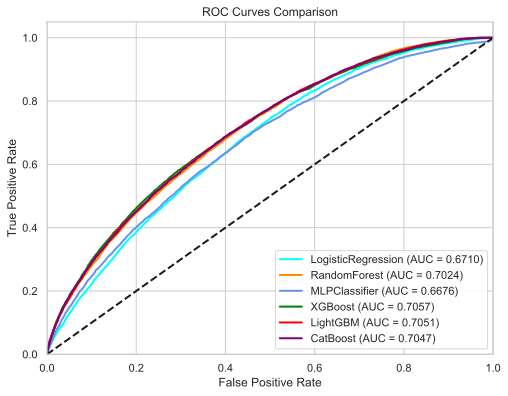

In [340]:
#---------------------------------------------------------------------------------------------------------
# Визуализация кривых roc_auc для всех полученных моделей
    # - pipe_models_list - список словарей с информацией о моделях
    # - pipe_final - лучшая финальная модель
#---------------------------------------------------------------------------------------------------------
# Подготовка данных для отображения графика
models_for_plot = []
for model in pipe_models_list:
    
    model_name = model['model_name']
    pipeline   = model['pipeline']
    
    models_for_plot.append({
                                'model_name': model_name,
                                'pipeline': pipeline
                            })
    
# Вызов функции визуализации
plot_roc_curves(x_test, y_test, models_for_plot, pipe_final=None)

### Важность признаков лучшей модели

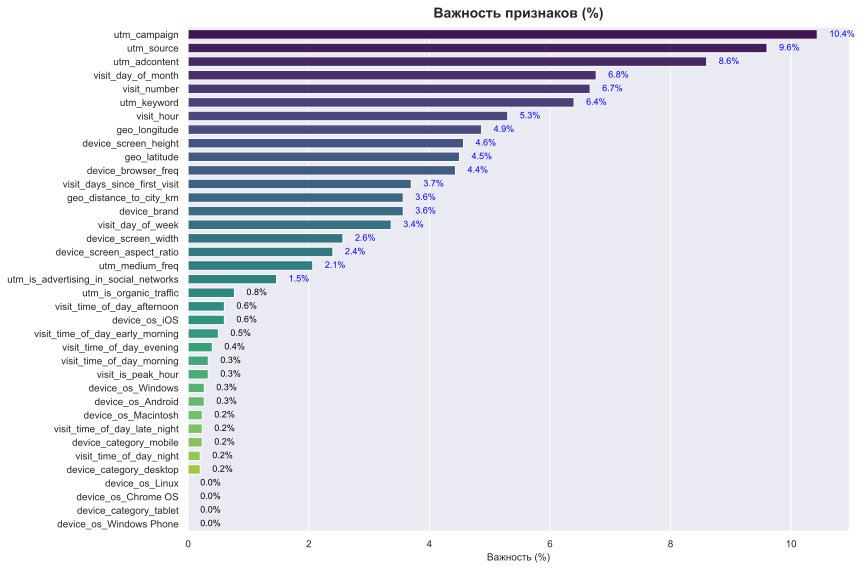

In [341]:
# Визуализация важности признаков финальной модели
model = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']
plot_features_importance(model, x_train_processed, top_n=50, figsize=(12, 8), font_scale=0.9, bar_width=0.7)

#### Важность признаков и групп признаков

In [405]:
model = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']
df_importance = get_features_importance_df(model, x_train_processed).head(50)

final_table = df_importance.copy()

# Добавляем столбец "группа признаков" (все до первого "_")
final_table['Высокая_важность'] = np.where( final_table['Важность_%'] > 4.0, '1', '')

final_table.insert(0, 'Группа', df_importance['Признак'].str.split('_').str[0])
final_table['Важность_группы_%'] = final_table.groupby('Группа')['Важность_%'].transform('sum')
# final_table.insert(1, 'Важность_группы_%', 0.0)

group_totals = final_table.groupby('Группа')['Важность_%'].sum().reset_index(name='Важность_группы_%')

final_table = final_table [ ['Группа', 'Важность_группы_%', 'Признак', 'Важность', 'Важность_%', 'Высокая_важность'] ]

#### Важность групп признаков в %

In [406]:
print(f'{s_bold}Важность групп признаков:')
group_totals.sort_values('Важность_группы_%', ascending=False)

Важность групп признаков:


,Группа,Важность_группы_%
2,utm,39.333333
3,visit,28.400000
0,device,19.333333
1,geo,12.933333


#### Важность признаков в % внутри групп

In [407]:
print(f'{s_bold}Важность признаков внутри групп:')
final_table.sort_values( ['Важность_группы_%', 'Важность_%'], ascending=[False, False])

Важность признаков внутри групп:


,Группа,Важность_группы_%,Признак,Важность,Важность_%,Высокая_важность
0,utm,39.333333,utm_campaign,313,10.433333,1
1,utm,39.333333,utm_source,288,9.600000,1
2,utm,39.333333,utm_adcontent,258,8.600000,1
5,utm,39.333333,utm_keyword,192,6.400000,1
17,utm,39.333333,utm_medium_freq,62,2.066667,
18,utm,39.333333,utm_is_advertising_in_social_networks,44,1.466667,
19,utm,39.333333,utm_is_organic_traffic,23,0.766667,
3,visit,28.400000,visit_day_of_month,203,6.766667,1
4,visit,28.400000,visit_number,200,6.666667,1
6,visit,28.400000,visit_hour,159,5.300000,1


In [414]:
final_table.loc[ (final_table['Высокая_важность'] == '1'), ['Группа', 'Признак', 'Важность_%', 'Важность_группы_%']].sort_values( ['Важность_группы_%', 'Важность_%'], ascending=[False, False])

,Группа,Признак,Важность_%,Важность_группы_%
0,utm,utm_campaign,10.433333,39.333333
1,utm,utm_source,9.600000,39.333333
2,utm,utm_adcontent,8.600000,39.333333
5,utm,utm_keyword,6.400000,39.333333
3,visit,visit_day_of_month,6.766667,28.400000
4,visit,visit_number,6.666667,28.400000
6,visit,visit_hour,5.300000,28.400000
8,device,device_screen_height,4.566667,19.333333
10,device,device_browser_freq,4.433333,19.333333
7,geo,geo_longitude,4.866667,12.933333


## Лучшая и Финальная модели

#### Подбор гиперпараметров для лучшей модели

In [342]:
%%time
# Подбор гиперпараметров для лучшей модели
if True:
    # параметры:
    # is_fit_pipeline - True или False:
        # признак, требуется ли обучение для pipeline
    # method_search - режим подбора:
        # grid   => GridSearchCV (полный перебор по сетке параметров)
        # random => RandomizedSearchCV (случайный выбор)
 
    search, pipe_model_best = tune_best_model( model_best_name=model_best_name, 
                                                  x_train=x_train, y_train=y_train, 
                                                  preprocessor=preprocessor, is_fit_pipeline=True, 
                                                  method_search='grid')

    # search, pipe_model_best = tune_best_model(model_best_name, x_train, y_train, preprocessor, 'grid')
    # search, pipe_model_best = tune_best_model(model_best_name, x_train_processed, y_train, preprocessor, 'random')
    
    df_search_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)


Tuning LightGBM ...; Method search: GridSearchCV
----------------------------------------------------------------------------------------------------
Выполняется функция: drop_columns_first ...
----------------------------------------------------------------------------------------------------
Выполняется функция: prepare_data_set_types ...
----------------------------------------------------------------------------------------------------
Выполняется ValueReplacer ...
----------------------------------------------------------------------------------------------------
Выполняется DeviceOSImputer ...
----------------------------------------------------------------------------------------------------
Выполняется GeoDataImputer ...
----------------------------------------------------------------------------------------------------
Выполняется FeatureGenerator ...
----------------------------------------------------------------------------------------------------
Выполняется GeoFeaturesGe

In [357]:
# Результаты кроссвалидации (по убыванию)
print(f"{s_bold}\nCV results:")
df_search_results.head(20)


CV results:


,params,mean_test_score
37,"{'classifier__feature_fraction': 0.9, 'classifier__learning_rate': 0.1, 'classifier__n_estimator...",0.697908
10,"{'classifier__feature_fraction': 0.8, 'classifier__learning_rate': 0.1, 'classifier__n_estimator...",0.697692
12,"{'classifier__feature_fraction': 0.8, 'classifier__learning_rate': 0.1, 'classifier__n_estimator...",0.697259
9,"{'classifier__feature_fraction': 0.8, 'classifier__learning_rate': 0.1, 'classifier__n_estimator...",0.697232
63,"{'classifier__feature_fraction': 1.0, 'classifier__learning_rate': 0.1, 'classifier__n_estimator...",0.697209
36,"{'classifier__feature_fraction': 0.9, 'classifier__learning_rate': 0.1, 'classifier__n_estimator...",0.696991
64,"{'classifier__feature_fraction': 1.0, 'classifier__learning_rate': 0.1, 'classifier__n_estimator...",0.696958
38,"{'classifier__feature_fraction': 0.9, 'classifier__learning_rate': 0.1, 'classifier__n_estimator...",0.695894
39,"{'classifier__feature_fraction': 0.9, 'classifier__learning_rate': 0.1, 'classifier__n_estimator...",0.695878
11,"{'classifier__feature_fraction': 0.8, 'classifier__learning_rate': 0.1, 'classifier__n_estimator...",0.695529


#### Обучение финальной модели на всех данных

In [343]:
%%time
# Обучение финальной модели на всех данных

# Загружаю полный датасет
# x, y, x_train, x_test, y_train, y_test = prepare_and_split_data(df_sessions, coef_classes=0)
# x_train_processed_full = preprocessor.fit_transform(x, y)

pipe_final, df_result_final = train_final_model(
                                                    model_best_name,
                                                    pipe_model_best.named_steps['classifier'].get_params(),
                                                    x,
                                                    y,
                                                    preprocessor
                                                )

df_result_final

----------------------------------------------------------------------------------------------------
Выполняется функция: drop_columns_first ...
----------------------------------------------------------------------------------------------------
Выполняется функция: prepare_data_set_types ...
----------------------------------------------------------------------------------------------------
Выполняется ValueReplacer ...
----------------------------------------------------------------------------------------------------
Выполняется DeviceOSImputer ...
----------------------------------------------------------------------------------------------------
Выполняется GeoDataImputer ...
----------------------------------------------------------------------------------------------------
Выполняется FeatureGenerator ...
----------------------------------------------------------------------------------------------------
Выполняется GeoFeaturesGenerator ...
--------------------------------------

,N,model_name,is_model_final,is_model_best,training_time,roc_auc_test,precision_test,recall_test,f1_test,acuracy_test,sep,roc_auc_train,precision_train,recall_train,f1_train,acuracy_train,parameters
0,2,LightGBM,1,1,294.17,0.7274,0.0464,0.74156,0.08734,0.58076,*,0.7274,0.0464,0.74156,0.08734,0.58076,"{'memory': None, 'steps': [('preprocessor', Pipeline(steps=[('drop_columns_first',\n ..."


#### Объединение результатов сравнения всех моделей и финальной модели

In [344]:
# Объединение результатов отбора моделей и финальной модели
df_resuls_all = pd.concat( [df_results, df_result_final])

# Вывод таблицы результатов всех моделей; в самом вверху списка - финальная и лучшая модели
# Сортировка: 
    # финальная модель, лучшая модель, остальные модели по убыванию метрики roc_auc_test
df_resuls_all.sort_values(['is_model_final', 'is_model_best', 'roc_auc_test'], ascending=[False, False, False])

,N,model_name,is_model_final,is_model_best,training_time,roc_auc_test,precision_test,recall_test,f1_test,acuracy_test,sep,roc_auc_train,precision_train,recall_train,f1_train,acuracy_train,parameters
0,2,LightGBM,1,1,294.17,0.72740,0.04640,0.74156,0.08734,0.58076,*,0.72740,0.04640,0.74156,0.08734,0.58076,"{'memory': None, 'steps': [('preprocessor', Pipeline(steps=[('drop_columns_first',\n ..."
4,5,LightGBM,0,1,2.30,0.70512,0.34886,0.99704,0.51687,0.37431,*,0.71981,0.34678,1.00000,0.51498,0.37322,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
3,4,XGBoost,0,0,0.80,0.70570,0.35540,0.98816,0.52277,0.39438,*,0.75317,0.35895,1.00000,0.52827,0.40575,"{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsam..."
5,6,CatBoost,0,0,24.85,0.70470,0.35338,0.99418,0.52143,0.38739,*,0.71917,0.35143,1.00000,0.52009,0.38591,"{'verbose': 0, 'random_state': 42, 'scale_pos_weight': 37}"
1,2,RandomForest,0,0,2.00,0.70238,0.44767,0.74166,0.55833,0.60611,*,0.71313,0.45099,0.74843,0.56283,0.61313,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_bins..."
0,1,LogisticRegression,0,0,2.58,0.67099,0.43703,0.69578,0.53685,0.59701,*,0.66616,0.43259,0.68972,0.53170,0.59573,"{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling'..."
2,3,MLPClassifier,0,0,41.34,0.66756,0.59111,0.15749,0.24871,0.68061,*,0.68256,0.59679,0.16212,0.25498,0.68475,"{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'e..."


#### Графики кривых ROC_AUC (с финальной моделью)

In [346]:
#---------------------------------------------------------------------------------------------------------
# Визуализация кривых roc_auc для всех полученных моделей
    # - pipe_models_list - список словарей с информацией о моделях
    # - pipe_final - лучшая финальная модель
#---------------------------------------------------------------------------------------------------------
# Подготовка данных для отображения графика
if False:
    models_for_plot = []
    for model in pipe_models_list:
        model_name = model['model_name']
        pipeline   = model['pipeline']
        
        models_for_plot.append({
                                    'model_name': model_name,
                                    'pipeline': pipeline
                                })
        
    # Вызов функции визуализации
    plot_roc_curves(x_test, y_test, models_for_plot, pipe_final)

## Запись и чтение модели

#### Запись модели в файл

In [369]:
# Запись модели в файл
if True:
    save_model(pipe_final, 'model_prediction_sber_final_(JN).pkl', round(metrics['roc_auc_test'], 4))

Model saved as file: models/model_prediction_sber_final_(JN).pkl


### Проверка. Загрузка модели из файла

In [362]:
# Проверка - Загрузка модели из файла
pipe_model_loaded = load_model('model_prediction_sber_final_(JN).pkl')
pipe_model_loaded

{'model': Pipeline(steps=[('preprocessor',
                  Pipeline(steps=[('drop_columns_first',
                                   FunctionTransformer(func=<function drop_columns_first at 0x0000014AD1D7D440>)),
                                  ('prepare_types',
                                   FunctionTransformer(func=<function prepare_data_set_types at 0x0000014AD1D7D120>)),
                                  ('column_transformer_imputers_simple',
                                   ColumnTransformer(remainder='passthrough',
                                                     transformers=[('imputer_con...
                                                                     'device_screen_aspect_ratio',
                                                                     'geo_latitude',
                                                                     'geo_longitude',
                                                                     'geo_distance_to_city_km'])],
          

#### Получение параметров загруженной модели

In [364]:
boosting_type = 'gbdt',
class_weight = None,
colsample_bytree = 1.0,
importance_type = 'split',
learning_rate = 0.1,
max_depth = -1,
min_child_samples = 20,
min_child_weight = 0.001,
min_split_gain = 0.0,
n_estimators = 100,
n_jobs = -1,
num_leaves = 50,
objective = None,
random_state = 42,
reg_alpha = 0.0,
reg_lambda = 0.0,
subsample = 1.0,
subsample_for_bin = 200000,
subsample_freq = 0,
scale_pos_weight = 37,
verbose = -1,
feature_fraction = 0.9

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 50,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'scale_pos_weight': 37,
 'verbose': -1,
 'feature_fraction': 0.9}

In [363]:
# Получение параметров загруженной модели
model_params = pipe_model_loaded['model'].named_steps['classifier'].get_params()

df_params = pd.DataFrame({
    'Параметр': model_params.keys(),
    'Значение': model_params.values()
})

print(df_params)

             Параметр Значение
0       boosting_type     gbdt
1        class_weight     None
2    colsample_bytree      1.0
3     importance_type    split
4       learning_rate      0.1
5           max_depth       -1
6   min_child_samples       20
7    min_child_weight    0.001
8      min_split_gain      0.0
9        n_estimators      100
10             n_jobs       -1
11         num_leaves       50
12          objective     None
13       random_state       42
14          reg_alpha      0.0
15         reg_lambda      0.0
16          subsample      1.0
17  subsample_for_bin   200000
18     subsample_freq        0
19   scale_pos_weight       37
20            verbose       -1
21   feature_fraction      0.9


## Тестирование модели, загруженной из файла

In [350]:
# Тестирование на примерах
def test_model_predictions(model, data, n_samples=100, target_col='target_event_action'):
    """
    Функция тестирует модель на N * 2 случайных примерах с расчетом Accuracy и ROC-AUC
    
    Параметры:
        - model      : обученная модель
        - data       : DataFrame с данными
        - n_samples  : количество тестовых примеров
        - target_col : название целевой колонки
    
    Возвращает:
        - results    : DataFrame с предсказаниями
        - metrics    : словарь с метриками
    """
    # model = model['model']
    
    # Выбираю случайные примеры (для класса 0 и для класса 1)
    test_samples_0 = data[data[target_col] == 0].sample(n_samples, random_state=42)
    test_samples_1 = data[data[target_col] == 1].sample(n_samples, random_state=42)
    test_samples   = pd.concat( [test_samples_0, test_samples_1])
    
    if test_samples.empty:
        print("Нет подходящих примеров для тестирования!")
        return None, None
    
    # Деление данных
    x_test = test_samples.drop(columns=[target_col])
    y_true = test_samples[target_col]
    
    # Предсказание
    y_pred = model.predict(x_test)
    
    # Проверяю возможность расчета ROC-AUC
    roc_auc = None
    if hasattr(model, 'predict_proba'):
        try:
            y_proba = model.predict_proba(x_test)[:, 1]
            roc_auc = roc_auc_score(y_true, y_proba)
        except Exception as e:
            print(f"Ошибка расчета ROC-AUC: {e}")
    
    # Считаю метрики
    accuracy = accuracy_score(y_true, y_pred)
    
    # DataFrame с результатами
    results = pd.DataFrame({
                                'y_valid':    y_true,
                                'y_predict':  y_pred,
                                'is_correct': (y_true == y_pred).astype(int)
                            })
    
    # Добавляю вероятности если есть
    if hasattr(model, 'predict_proba') and 'y_proba' in locals():
        results['prediction_prob'] = y_proba
    
    # Формирую метрики
    metrics = {
                'accuracy':  accuracy,
                'roc_auc':   roc_auc,
                'n_samples': n_samples * 2
            }
    
    # Вывод результатов
    print(f"{s_bold}\nРезультаты тестирования на {n_samples * 2} примерах: {n_samples} (target = 0) + {n_samples} (target = 1):")
    print(f"{s_bold}Accuracy: {accuracy:.4f}")
    if roc_auc is not None:
        print(f"{s_bold}ROC-AUC: {roc_auc:.4f}")
    
    return results, metrics

In [351]:
test_model_predictions(pipe_model_loaded['model'], df_sessions, 1000)

----------------------------------------------------------------------------------------------------
Выполняется функция: drop_columns_first ...
----------------------------------------------------------------------------------------------------
Выполняется функция: prepare_data_set_types ...
----------------------------------------------------------------------------------------------------
Выполняется ValueReplacer ...
----------------------------------------------------------------------------------------------------
Выполняется DeviceOSImputer ...
----------------------------------------------------------------------------------------------------
Выполняется GeoDataImputer ...
----------------------------------------------------------------------------------------------------
Выполняется FeatureGenerator ...
----------------------------------------------------------------------------------------------------
Выполняется GeoFeaturesGenerator ...
--------------------------------------

(         y_valid  y_predict  is_correct  prediction_prob
 1016929        0          1           0         0.948003
 70282          0          1           0         0.938566
 1456683        0          1           0         0.950041
 140234         0          1           0         0.930703
 591414         0          1           0         0.962006
 ...          ...        ...         ...              ...
 1276582        1          1           1         0.928491
 94178          1          1           1         0.951502
 1213326        1          1           1         0.985236
 86064          1          1           1         0.976574
 1238296        1          1           1         0.926785
 
 [2000 rows x 4 columns],
 {'accuracy': 0.5295, 'roc_auc': 0.7276015, 'n_samples': 2000})

In [352]:
get_duration_time(dt_start)

Начало = 2025-07-22 (09:16:17);  Окончание = 2025-07-22 (09:45:26);  Продолжительность = (0:29:08)
